In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tqdm import tqdm
import os
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from IPython.core.display import display, HTML

In [2]:
global_durations=[]
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.lr = 0.01
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf
        self.initial_epoch=initial_epoch 
        self.batches=batches
        self.durations=[]
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        

    def on_train_begin(self, logs=None):
        print(f' Starting training using base model InceptionV3')            
        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration'))
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        print('Training is completed - model is set with weights for the epoch with the lowest loss')
        print(self.durations)
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count   
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        self.durations.append(duration)
        global_durations.append(duration)
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc >= self.threshold: # adjust learning rate based on validation loss     
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count < self.patience-1: 
                    self.count =self.count +1 # increment the patience counter  
                else: 
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                if acc>self.highest_tracc:
                    self.highest_tracc= acc          
        else: # adjust learning rate based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                self.lr=lr
            else: 
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch+1 >= self.ask_epoch:
                    print(f'training has been halted at epoch {epoch + 1} due to user input')
                    self.model.stop_training = True # stop training

In [3]:
# Plot function - also plots curve for training times against no. of epochs
def tr_plot(tr_data, training_times, start_epoch):
    #Plot the training and validation data
    train_acc=tr_data.history['accuracy']
    train_loss=tr_data.history['loss']
    val_acc=tr_data.history['val_accuracy']
    val_loss=tr_data.history['val_loss']
    Epoch_count=len(train_acc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(val_loss)#  this is the epoch with the lowest validation loss
    val_lowest=val_loss[index_loss]
    index_acc=np.argmax(val_acc)
    acc_highest=val_acc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,ax=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    ax[0].plot(Epochs,train_loss, 'r', label='Training loss')
    ax[0].plot(Epochs,val_loss,'g',label='Validation loss' )
    ax[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot (Epochs,train_acc,'r',label= 'Training Accuracy')
    ax[1].plot (Epochs,val_acc,'g',label= 'Validation Accuracy')
    ax[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    training_times_cumu = [x/60 for x in training_times]
    training_times_cumu = [sum(training_times_cumu[0:i+1]) for i in range(0,len(training_times_cumu))]
    print(training_times_cumu)
    ax[2].plot (Epochs,training_times_cumu,'r',label= 'Epoch Training Times')
    ax[2].set_title('Epoch Training Times')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Training Time (in minutes)')
    ax[2].legend()    
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [4]:
train_list_filenames=[]
train_list_labels=[]
dstpath='../input/covidx-cxr2/train'
test_df = pd.read_csv('../input/covidx-cxr2/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("../input/covidx-cxr2/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0          ../input/covidx-cxr2/train/ARDSSevere.png  negative
1  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
2  ../input/covidx-cxr2/train/acute-respiratory-d...  negative
3  ../input/covidx-cxr2/train/ards-secondary-to-t...  negative
4  ../input/covidx-cxr2/train/pneumocystis-pneumo...  negative
positive    15994
negative    13992
Name: labels, dtype: int64


In [5]:
file_count = 5000
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

negative    2200
positive    2200
Name: labels, dtype: int64
4400


In [6]:
### partition df into a train_df and a valid_df and make generators
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)
print('Initial train and test split')
#print(valid_df['labels'].ravel())
print(len(valid_df))
height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=0.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print('head of validation dataframe:', valid_df.head())
#print(valid_df['labels'].ravel())
print('debug point')
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
generator=ImageDataGenerator(preprocessing_function=scalar)
train_gen=generator.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
length= len(test_df) # determine test batch size and test steps such that test_batch_size X test_steps = number of test samples
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size) 
test_gen=generator.flow_from_dataframe( test_df, '../input/covidx-cxr2/test', x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=generator.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
train_steps=int(len(train_gen.labels)/batch_size)

Initial train and test split
440
head of validation dataframe:                                               filenames    labels
3760  ../input/covidx-cxr2/train/ea9d7193-35cb-4e5b-...  negative
2511  ../input/covidx-cxr2/train/A899201-01-11-1901-...  positive
3105  ../input/covidx-cxr2/train/70d2139e-967a-4fa9-...  negative
4011  ../input/covidx-cxr2/train/d640b82b-9fa6-49ad-...  negative
926   ../input/covidx-cxr2/train/A492240-12-31-1900-...  positive
debug point
train samples:  3960   test samples:  400  validation samples 440
Found 3960 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 440 validated image filenames belonging to 2 classes.


# **Code for GridSearch CV for Inception**  - to determine the best combination of LR and optimizer

In [7]:
results = {}
gs_lrs = [0.0001, 0.001, 0.01, 0.1]
gs_optimizers = ['adam', 'sgd', 'sgdm']
for l in gs_lrs:
    for gs_optimizer in gs_optimizers:
        if gs_optimizer == 'adam':
            opt = Adam(lr = l)
        elif gs_optimizer == 'sgdm':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.9, nesterov=True)
        elif gs_optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate = l, decay=1e-6, momentum=0.0, nesterov=True)

        base_model=tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        x=base_model.output
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(128,activation='relu')(x)
        x=Dropout(rate=.3, seed=123)(x)        
        output=Dense(class_count, activation='softmax')(x)
        model=Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
#         model = tf.keras.Sequential([
#             base_model, 
#             tf.keras.layers.GlobalAveragePooling2D(), 
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.BatchNormalization(), 
#             tf.keras.layers.Dropout(0.2), 
#             tf.keras.layers.Dense(1, activation='sigmoid')
#         ])
#         model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'Precision', 'Recall', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

        patience = 1
        stop_patience = 10
        factor = 0.5
        class TimeHistory(keras.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.times = []

            def on_epoch_begin(self, batch, logs={}):
                self.epoch_time_start = time.time()

            def on_epoch_end(self, batch, logs={}):
                self.times.append(time.time() - self.epoch_time_start)
        time_callback = TimeHistory()

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
            tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
            time_callback
        ]

        epochs = 10
        history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)
        results[(gs_optimizer,l)] = history.history['val_accuracy'][-1]

In [8]:
def plot_learning_rates(results):
    Adam =[]
    SGD = []
    SGDM = []
    
    for k,v in results.items():
        if(k[0] == 'adam'):
            Adam.append([k[1],v])
        if(k[0] == 'sgd'):
            SGD.append([k[1],v])
        if(k[0] == 'sgdm'):
            SGDM.append([k[1],v])   
    
    lrs = [x[0] for x in sorted(Adam, key = lambda x: x[0])]
    Adam = [x[1] for x in sorted(Adam, key = lambda x: x[0])]
    SGD = [x[1] for x in sorted(SGD, key = lambda x: x[0])]
    SGDM = [x[1] for x in sorted(SGDM, key = lambda x: x[0])]
      
    print(lrs, Adam, SGD, SGDM)
  
    plt.style.use('fivethirtyeight')
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(20,8))
    
    axes[0].plot(range(len(lrs)),Adam,'r',label= 'Validation Accuracy')
    axes[0].set_title('Adam')
    axes[0].set_xticks(range(len(lrs)))
    axes[0].set_xticklabels(lrs)
    axes[0].set_xlabel('Learning Rate')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].legend()  
    
    axes[1].plot (range(len(lrs)),SGD,'r',label= 'Validation Accuracy')
    axes[1].set_title('SGD')
    axes[1].set_xticks(range(len(lrs)))
    axes[1].set_xticklabels(lrs)    
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].legend() 

    axes[2].plot (range(len(lrs)),SGDM,'r',label= 'Validation Accuracy')
    axes[2].set_title('SGDM')
    axes[2].set_xticks(range(len(lrs)))
    axes[2].set_xticklabels(lrs)     
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [9]:
plot_learning_rates(results)

In [10]:
Plot the results
import matplotlib.pyplot as plt
import numpy as np
dicts = {('adam', 0.0001): 0.9305555820465088, ('sgd', 0.0001): 0.7615740895271301, ('sgdm', 0.0001): 0.8958333134651184, ('adam', 0.001): 0.9560185074806213, ('sgd', 0.001): 0.8865740895271301, ('sgdm', 0.001): 0.9629629850387573, ('adam', 0.01): 0.6111111044883728, ('sgd', 0.01): 0.9722222089767456, ('sgdm', 0.01): 0.9652777910232544, ('adam', 0.1): 0.5023148059844971, ('sgd', 0.1): 0.9583333134651184, ('sgdm', 0.1): 0.49768519401550293}
fig, ax = plt.subplots(1,1)
# hyper-parameters
learning_rate =  [0.0001, 0.001, 0.01, 0.1]
opt =  ['adam', 'sgd', 'sgdm']
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(opt)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(learning_rate)
arr = np.zeros([3, 4])

print(dict)
# loop over the different combinations of the hyper-parameters selected for our experiment.
for i in range(len(opt)):
    for j in range(len(learning_rate)):
        # add the values corresponding to combinations of hyper-parameters to an numpy array
        arr[i][j] = dicts[(opt[i], learning_rate[j])] * 100
arr = np.around(arr, 3)
plt.grid(False)
plt.xlabel('Optimizer')
plt.ylabel('Learning Rate')
plt.title('Testing accuracy vs Optimizer and Learning Rate')
plt.imshow(arr, cmap='hot', interpolation='nearest')

for (j,i),label in np.ndenumerate(arr):
    ax.text(i,j,label,ha='center',va='center', color='green')

fig.savefig('heat_map_gs_dpo_pool.png')
plt.show()

# **GridSearch ends here. Best parameters are used to construct the final model**

In [11]:
### create the model
class_dict=train_gen.class_indices
classes=list(class_dict.keys()) 
class_count=len(classes)
model_name='InceptionV3'
base_model=tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.01, epsilon=0.001 )(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(SGD(lr=.01), loss='binary_crossentropy', metrics=['accuracy']) 

2022-12-07 02:33:28.558282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:33:28.559303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:33:28.705663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:33:28.706522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 02:33:28.707377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
### instantiate the calback and train the model
epochs = 40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model InceptionV3
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration


2022-12-07 02:33:38.275388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-07 02:33:47.426447: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


training has been halted at epoch 10 due to user inputuracy=   99.697  loss:  2.72511 
Training is completed - model is set with weights for the epoch with the lowest loss
[121.59809875488281, 64.05900931358337, 62.287901639938354, 64.52808737754822, 64.02361607551575, 65.78959512710571, 63.378114223480225, 63.61216974258423, 64.59348225593567, 63.81019330024719]


[2.0266349792480467, 3.094285134474436, 4.132416828473409, 5.207884951432546, 6.274945219357809, 7.371438471476237, 8.427740375200907, 9.487943204243978, 10.564501241842905, 11.62800446351369]


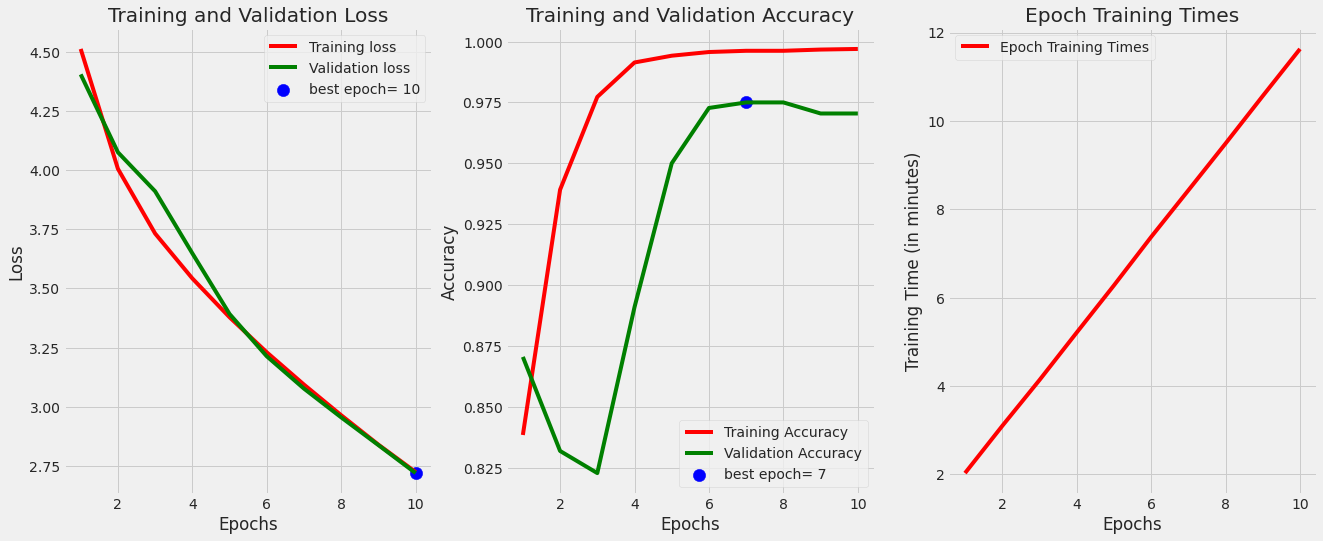

8/8 [==============================] - 27s 3s/step - loss: 2.8721 - accuracy: 0.9100
Model accuracy on test set: 91.00000262260437


In [13]:
### plot the data and evaluate the model on the test set
tr_plot(history, global_durations, 0)
acc=model.evaluate(test_gen,batch_size=test_batch_size, steps=test_steps, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg)

In [15]:
### save the model
save_dir=r'./'
subject='covid'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

# **ROC curve and calculation of AUC**

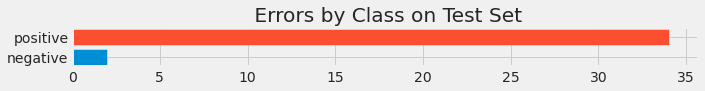

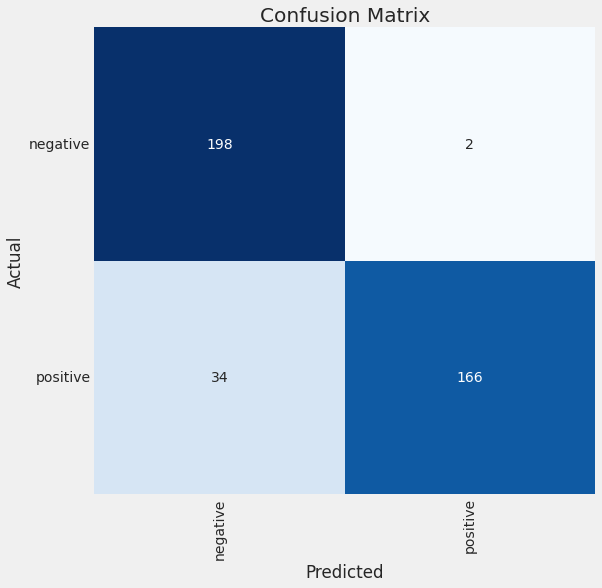

Classification Report:
----------------------
               precision    recall  f1-score   support

    negative       0.85      0.99      0.92       200
    positive       0.99      0.83      0.90       200

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400

[9.99875903e-01 9.99654412e-01 9.72054183e-01 9.99753654e-01
 9.99603450e-01 7.55746603e-01 9.99852061e-01 9.96716917e-01
 9.18188751e-01 9.99597847e-01 9.99622583e-01 9.99633670e-01
 9.99689937e-01 2.63000429e-02 9.81258273e-01 9.79884267e-01
 9.70409393e-01 9.99460995e-01 4.59238276e-04 9.99763310e-01
 9.99624491e-01 1.41106555e-02 9.99994874e-01 9.99434769e-01
 3.25417183e-02 9.99692678e-01 9.99199688e-01 9.99729216e-01
 3.87560274e-03 9.83256638e-01 9.96047914e-01 9.99755800e-01
 3.78236026e-02 9.98558819e-01 9.99754727e-01 6.47118874e-03
 1.78853795e-01 9.94791508e-01 9.99855399e-01 3.53612332e-03
 1.43543497e-01 

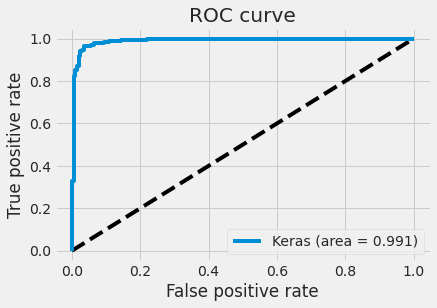

In [16]:
#ROC curve and calculation of AUC
from sklearn.metrics import auc
print_code=0
y_pred_keras=model.predict(test_gen)
#print(y_pred_keras)
print_infos( test_gen, y_pred_keras, print_code, save_dir, subject )  

preds = y_pred_keras
class_dict=test_gen.class_indices
labels= test_gen.labels
file_names= test_gen.filenames 
error_list=[]
true_class=[]
pred_class=[]
prob_list=[]
new_dict={}
error_indices=[]
y_pred=[]
for key,value in class_dict.items():
    new_dict[value]=key             # dictionary {integer of class number: string of class name}
# store new_dict as a text fine in the save_dir
classes=list(new_dict.values())     # list of string of class names
dict_as_text=str(new_dict)
dict_name= subject + '-' +str(len(classes)) +'.txt'  
dict_path=os.path.join(save_dir,dict_name)    
with open(dict_path, 'w') as x_file:
    x_file.write(dict_as_text)    
errors=0      
for i, p in enumerate(preds):
    pred_index=np.argmax(p)        
    true_index=labels[i]  # labels are integer values
    if pred_index != true_index: # a misclassification has occurred
        error_list.append(file_names[i])
        true_class.append(new_dict[true_index])
        pred_class.append(new_dict[pred_index])
        prob_list.append(p[pred_index])
        error_indices.append(true_index)            
        errors=errors + 1
    y_pred.append(pred_index)    
if print_code !=0:
    if errors>0:
        if print_code>errors:
            r=errors
        else:
            r=print_code           
        msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
        print_in_color(msg, (0,255,0),(55,65,80))
        for i in range(r):
            msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
            print_in_color(msg, (255,255,255), (55,65,60))
            #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
    else:
        msg='With accuracy of 100 % there are no errors to print'
        print_in_color(msg, (0,255,0),(55,65,80))
if errors>0:
    plot_bar=[]
    plot_class=[]
    for  key, value in new_dict.items():        
        count=error_indices.count(key) 
        if count!=0:
            plot_bar.append(count) # list containg how many times a class c had an error
            plot_class.append(value)   # stores the class 
    fig=plt.figure()
    fig.set_figheight(len(plot_class)/3)
    fig.set_figwidth(10)
    plt.style.use('fivethirtyeight')
    for i in range(0, len(plot_class)):
        c=plot_class[i]
        x=plot_bar[i]
        plt.barh(c, x, )
        plt.title( ' Errors by Class on Test Set')

if len(classes)<= 30:
    # create a confusion matrix and a test report        
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)        
    cm = confusion_matrix(y_true, y_pred )
    clr = classification_report(y_true, y_pred, target_names=classes)
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90)
    plt.yticks(np.arange(length)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()    
    print("Classification Report:\n----------------------\n", clr)


new = y_pred_keras[:, 1]
print(new)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.labels, new)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# **Evaluate the model on test dataset:**

In [17]:
records = model.evaluate(test_gen)

8/8 [==============================] - 20s 2s/step - loss: 2.8721 - accuracy: 0.9100
